/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipython-input-609531014.py:177: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(summarize_stability(g)))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipython-input-609531014.py:235: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col


=== Part 1: Convergence stability (lower is better; negative beta is good) ===
 index        encoding        family  n_points  mean_abs_error  median_abs_error  min_abs_error  spearman_like_corr_len_vs_abs_err  loglog_beta(|err|~N^beta)
     1 binary_fraction Sturmian_1/pi      61.0      115.009857        115.009857     115.009857                                NaN              -1.904246e-17
     2 binary_fraction Sturmian_s2m1      61.0      432.113839        432.113839     432.113839                                NaN              -2.417866e-17
     3 binary_fraction    Thue-Morse      61.0     1318.366969       1318.366969    1318.366969                                NaN              -3.980431e-16
     0 binary_fraction        Rabbit      61.0     2381.446122       2381.446122    2381.446122                                NaN               5.007484e-16
     4   decimal_bigit        Rabbit      61.0        1.508707          1.508707       1.508707                                NaN

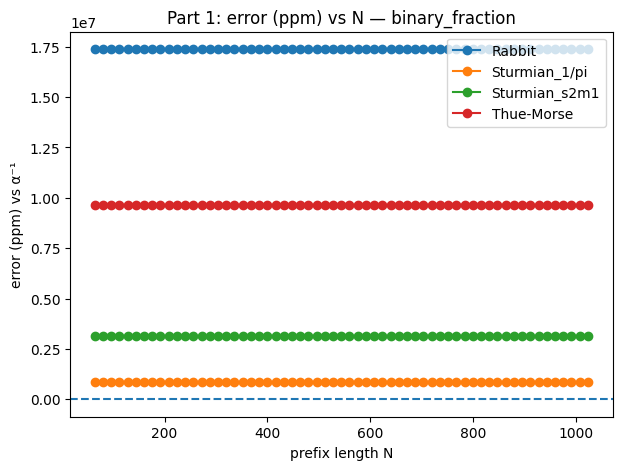

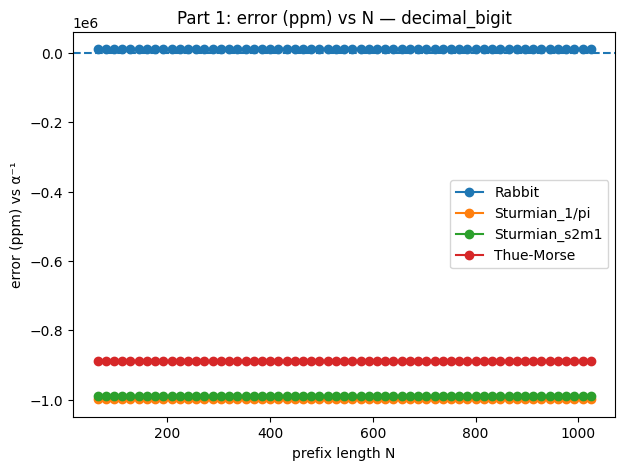

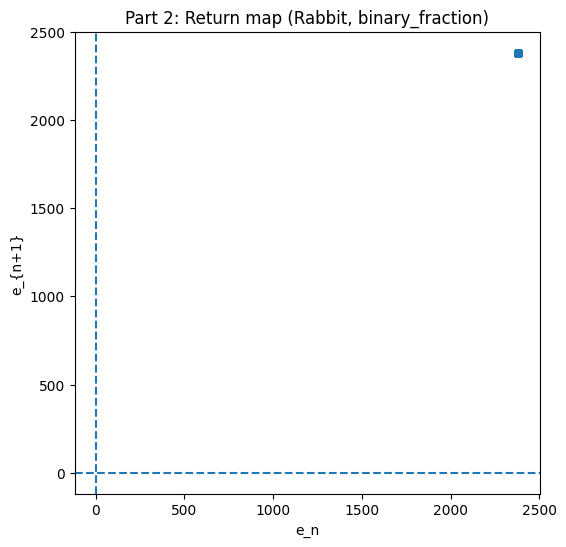

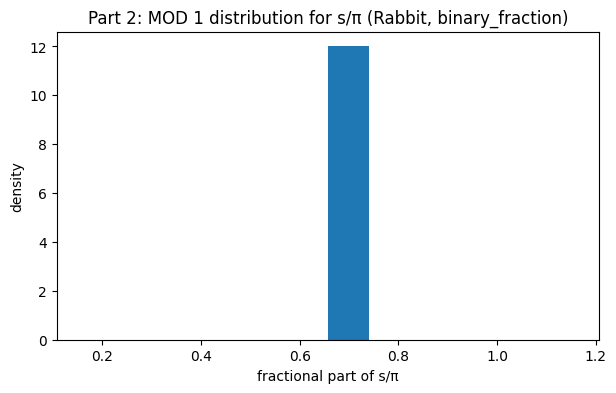

In [1]:
# @title Two-Part Stability Test: Convergence + Self-Stabilizing Divergence ("Extras")
# @markdown **Fixed targets & rules (pre-declared)**
# @markdown - Target constant: alpha_inv = 137.035999
# @markdown - Families: Rabbit, Sturmian(√2−1), Sturmian(1/π), Thue–Morse (control)
# @markdown - Denominator (fixed): Fibonacci word F
# @markdown - Encodings (both tested):
# @markdown   1) Decimal-bigit: scaled_dec = ((A/F)/729) * 1e4
# @markdown   2) Binary-fraction: scaled_bin = (x_A/x_F) * 2^10
# @markdown
# @markdown **Part 1 — Convergence panel:** error vs α⁻¹ across N, with stability summaries.
# @markdown **Part 2 — Extras:** oscillation bandwidth, sign changes, plateaus, FFT peak ratio,
# @markdown return-map autocorr, and pre-declared weaving transforms vs {π, φ, √2, e, γ, G, ζ(3)}.

import math, statistics, itertools, sys, typing, warnings
from decimal import Decimal, getcontext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.stats import kstest
    have_scipy = True
except Exception:
    have_scipy = False
    warnings.warn("SciPy not found; KS tests will be skipped.")

# ---------- Parameters ----------
alpha_inv = Decimal("137.035999")
alpha     = Decimal(1) / alpha_inv
pi        = Decimal(str(math.pi))
phi       = Decimal((1 + 5**0.5) / 2)
sqrt2     = Decimal(str(math.sqrt(2)))
econst    = Decimal(str(math.e))
gamma     = Decimal("0.57721566490153286060")  # Euler–Mascheroni
catalanG  = Decimal("0.91596559417721901505")
zeta3     = Decimal("1.20205690315959428540")

C_norm    = Decimal(729)    # 9^3
SCALE10   = Decimal(10_000) # 1e4
BIN_SCALE = Decimal(2) ** 10

# prefix lengths (uniform spacing to allow FFT): 64..1024 by 16 (61 samples)
lengths = list(range(64, 1025, 16))

# decimal precision: enough for longest bigit
getcontext().prec = max(lengths) + 80

# ---------- Word builders (build once to N_max, then slice) ----------
def build_fib_word(N: int) -> str:
    s = "0"
    while len(s) < N:
        s = s.replace("0","X").replace("1","Y")
        s = s.replace("X","01").replace("Y","0")
    return s[:N]

def build_rabbit_word(N: int) -> str:
    a, b = "1", "10"
    while len(b) < N:
        a, b = b, a + b
    return b[:N]

def thue_morse(N: int) -> str:
    out = []
    for i in range(N):
        out.append(str(bin(i).count("1") & 1))
    return "".join(out)

def sturmian_word(N: int, slope: float, intercept: float=0.0) -> str:
    bits = []
    f = math.floor
    for k in range(N):
        b = f((k+1)*slope + intercept) - f(k*slope + intercept)
        bits.append("1" if b == 1 else "0")
    return "".join(bits)

# Build to max length once
Nmax = max(lengths)
F_full = build_fib_word(Nmax)
R_full = build_rabbit_word(Nmax)
TM_full = thue_morse(Nmax)
S1_full = sturmian_word(Nmax, slope=math.sqrt(2)-1.0, intercept=0.0)
S2_full = sturmian_word(Nmax, slope=1.0/math.pi, intercept=0.0)

FAMILIES = {
    "Rabbit":       R_full,
    "Sturmian_s2m1":S1_full,
    "Sturmian_1/pi":S2_full,
    "Thue-Morse":   TM_full,
}

# ---------- Encodings ----------
def bigit_decimal(bits: str) -> Decimal:
    # Interpret as "0."+bits in base 10 (digits are 0/1)
    return Decimal("0." + bits) if bits else Decimal(0)

def binary_fraction_decimal(bits: str) -> Decimal:
    # Value in base-2 as sum b_k * 2^{-k} using Decimal
    acc = Decimal(0)
    twopow = Decimal(1)
    for ch in bits:
        twopow = twopow / 2
        if ch == "1":
            acc += twopow
    return acc

def ones_density(bits: str) -> float:
    return bits.count("1") / max(1, len(bits))

# ---------- Fixed rules ----------
def scaled_decimal_rule(A_dec: Decimal, F_dec: Decimal) -> Decimal:
    if F_dec == 0: return Decimal("NaN")
    return (A_dec / F_dec) / C_norm * SCALE10

def scaled_binary_rule(A_bin: Decimal, F_bin: Decimal) -> Decimal:
    if F_bin == 0: return Decimal("NaN")
    return (A_bin / F_bin) * BIN_SCALE

# ---------- Sweep ----------
rows = []
for n in lengths:
    F_bits = F_full[:n]
    F_dec  = bigit_decimal(F_bits)
    F_bin  = binary_fraction_decimal(F_bits)

    for fam_name, full_bits in FAMILIES.items():
        A_bits = full_bits[:n]
        A_dec  = bigit_decimal(A_bits)
        A_bin  = binary_fraction_decimal(A_bits)

        scaled_dec = scaled_decimal_rule(A_dec, F_dec)
        scaled_bin = scaled_binary_rule(A_bin, F_bin)

        for enc_name, scaled in (("decimal_bigit", scaled_dec), ("binary_fraction", scaled_bin)):
            err = scaled - alpha_inv
            ppm = (err / alpha_inv) * Decimal(1_000_000)

            rows.append({
                "length": n, "family": fam_name, "encoding": enc_name,
                "ones_density_A": ones_density(A_bits),
                "ones_density_F": ones_density(F_bits),
                "scaled": float(scaled), "error": float(err), "error_ppm": float(ppm),
            })

df = pd.DataFrame(rows).sort_values(["encoding","family","length"]).reset_index(drop=True)

# ---------- Part 1: Convergence summaries ----------
def summarize_stability(sub: pd.DataFrame) -> dict:
    e = sub["error"].to_numpy()
    N = sub["length"].to_numpy()

    # rank corr of |e| vs N (negative => errors shrink)
    abs_e = np.abs(e)
    try:
        rank_len = pd.Series(N).rank().to_numpy()
        rank_err = pd.Series(abs_e).rank().to_numpy()
        corr_rank = float(np.corrcoef(rank_len, rank_err)[0,1])
    except Exception:
        corr_rank = float("nan")

    # log–log slope beta: |e| ~ N^beta
    mask = (abs_e > 0) & (N > 0)
    if mask.sum() >= 2:
        beta = float(np.polyfit(np.log(N[mask]), np.log(abs_e[mask]), 1)[0])
    else:
        beta = float("nan")

    return {
        "n_points": len(sub),
        "mean_abs_error": float(abs_e.mean()),
        "median_abs_error": float(np.median(abs_e)),
        "min_abs_error": float(abs_e.min()),
        "spearman_like_corr_len_vs_abs_err": corr_rank,
        "loglog_beta(|err|~N^beta)": beta,
    }

stab_summary = (df.groupby(["encoding","family"], as_index=False, group_keys=False)
                  .apply(lambda g: pd.Series(summarize_stability(g)))
                  .reset_index())

# ---------- Part 2: Self-stabilizing divergence (“extras”) ----------
def extras_metrics(sub: pd.DataFrame, rounding=6) -> dict:
    # sequence is uniformly sampled in N by construction
    e = sub["error"].to_numpy()
    s = sub["scaled"].to_numpy()

    # (a) Bandwidth (95% interval width) and MAD
    q05, q95 = np.quantile(e, [0.05, 0.95])
    bandwidth_95 = float(q95 - q05)
    mad = float(np.median(np.abs(e - np.median(e))))

    # (b) Sign-change rate
    signs = np.sign(e)
    sc = int(np.sum(np.diff(signs) != 0))
    sign_change_rate = sc / max(1, len(e)-1)

    # (c) Plateau index: median run length after rounding scaled values
    rounded = np.round(s, decimals=rounding)
    run_lengths = []
    if len(rounded) > 0:
        cur = rounded[0]; run = 1
        for x in rounded[1:]:
            if x == cur: run += 1
            else:
                run_lengths.append(run); cur = x; run = 1
        run_lengths.append(run)
    plateau_median_run = float(np.median(run_lengths)) if run_lengths else 0.0

    # (d) FFT spectral peak ratio: max|FFT(k>0)| / |DC|
    x = e - np.mean(e)
    fft = np.fft.rfft(x)
    mag = np.abs(fft)
    if len(mag) > 1:
        dc = mag[0]
        peak = mag[1:].max()
        spectral_peak_ratio = float(peak / (dc + 1e-12))
    else:
        spectral_peak_ratio = float("nan")

    # (e) Return-map autocorr corr(e_n, e_{n+1})
    if len(e) >= 2:
        autocorr = float(np.corrcoef(e[:-1], e[1:])[0,1])
    else:
        autocorr = float("nan")

    return {
        "bandwidth95": bandwidth_95,
        "MAD": mad,
        "sign_change_rate": float(sign_change_rate),
        "plateau_median_run(len rounded=6)": plateau_median_run,
        "spectral_peak_ratio": spectral_peak_ratio,
        "lag1_autocorr": autocorr,
    }

extras = (df.groupby(["encoding","family"], as_index=False, group_keys=False)
            .apply(lambda g: pd.Series(extras_metrics(g)))
            .reset_index())

# ---------- Weaving transforms vs constants ----------
CONST_SET = {
    "alpha_inv": alpha_inv, "alpha": alpha, "pi": pi, "pi/2": pi/2, "phi": phi,
    "sqrt2": sqrt2, "e": econst, "gamma": gamma, "CatalanG": catalanG, "zeta3": zeta3,
}
def frac_part(x: float) -> float:
    # fractional part in [0,1)
    return x - math.floor(x)

TRANSFORMS = {
    "s":           lambda s: s,
    "1/s":         lambda s: (1.0/s if s != 0 else np.nan),
    "s/alpha_inv": lambda s: s / float(alpha_inv),
    "s*alpha":     lambda s: s * float(alpha),
    "s/pi":        lambda s: s / math.pi,
    "s*pi":        lambda s: s * math.pi,
    "s/phi":       lambda s: s / ((1+5**0.5)/2),
    "s*phi":       lambda s: s * ((1+5**0.5)/2),
}

def weaving_summary(sub: pd.DataFrame) -> pd.DataFrame:
    s = sub["scaled"].to_numpy()
    rows = []
    for tname, tf in TRANSFORMS.items():
        y = np.array([tf(v) for v in s], dtype=float)
        # distance to nearest integer & half-integer
        frac = np.array([frac_part(v) for v in y if np.isfinite(v)], dtype=float)
        if len(frac) == 0:
            mean_dist_int = mean_dist_half = float("nan")
            ks_p = float("nan")
        else:
            dist_to_int  = np.minimum(frac, 1-frac)
            dist_to_half = np.abs(frac - 0.5)
            mean_dist_int  = float(dist_to_int.mean())
            mean_dist_half = float(dist_to_half.mean())

            if have_scipy:
                ks_p = float(kstest(frac, 'uniform', args=(0,1)).pvalue)
            else:
                ks_p = float("nan")

        rows.append({
            "transform": tname,
            "mean_frac_dist_to_int":  mean_dist_int,
            "mean_frac_dist_to_half": mean_dist_half,
            "KS_p_uniform_mod1": ks_p,
        })
    return pd.DataFrame(rows)

weave_tables = []
for (enc,fam), sub in df.groupby(["encoding","family"]):
    wtab = weaving_summary(sub)
    wtab.insert(0, "encoding", enc)
    wtab.insert(1, "family", fam)
    weave_tables.append(wtab)
weave_df = pd.concat(weave_tables, ignore_index=True)

# ---------- Display: concise consoles ----------
print("\n=== Part 1: Convergence stability (lower is better; negative beta is good) ===")
print(stab_summary.sort_values(["encoding","median_abs_error"]).to_string(index=False))

print("\n=== Part 2A: Extras metrics (oscillation signature) ===")
print(extras.sort_values(["encoding","family"]).to_string(index=False))

print("\n=== Part 2B: Weaving transforms (mod-1 closeness; smaller mean_frac_dist_to_int/half is stronger), KS p<0.05 suggests non-uniform clustering ===")
print(weave_df.sort_values(["encoding","family","mean_frac_dist_to_int"]).to_string(index=False))

# Save CSVs
df.to_csv("/content/part1_rows_all.csv", index=False)
stab_summary.to_csv("/content/part1_stability_summary.csv", index=False)
extras.to_csv("/content/part2_extras_metrics.csv", index=False)
weave_df.to_csv("/content/part2_weaving_mod1.csv", index=False)
print("\nSaved:")
print(" - /content/part1_rows_all.csv")
print(" - /content/part1_stability_summary.csv")
print(" - /content/part2_extras_metrics.csv")
print(" - /content/part2_weaving_mod1.csv")

# ---------- Minimal plots (toggle by setting to False) ----------
show_plots = True
if show_plots:
    # Error vs N (ppm), per encoding
    for enc in df["encoding"].unique():
        plt.figure(figsize=(7,5))
        for fam, sub in df[df["encoding"]==enc].groupby("family"):
            plt.plot(sub["length"], sub["error_ppm"], marker="o", label=fam)
        plt.axhline(0, linestyle="--")
        plt.xlabel("prefix length N")
        plt.ylabel("error (ppm) vs α⁻¹")
        plt.title(f"Part 1: error (ppm) vs N — {enc}")
        plt.legend()
        plt.show()

    # Return map e_{n+1} vs e_n to visualize cycles (binary_fraction, Rabbit)
    sub = df[(df["encoding"]=="binary_fraction") & (df["family"]=="Rabbit")].sort_values("length")
    if len(sub) >= 2:
        e = sub["error"].to_numpy()
        plt.figure(figsize=(6,6))
        plt.scatter(e[:-1], e[1:], s=30)
        plt.xlabel("e_n")
        plt.ylabel("e_{n+1}")
        plt.title("Part 2: Return map (Rabbit, binary_fraction)")
        plt.axhline(0, linestyle="--"); plt.axvline(0, linestyle="--")
        plt.show()

    # MOD 1 histogram for a weaving transform example (binary_fraction, Rabbit, s/pi)
    sub = df[(df["encoding"]=="binary_fraction") & (df["family"]=="Rabbit")]
    svals = sub["scaled"].to_numpy()
    frac = np.array([ (v/math.pi) - math.floor((v/math.pi)) for v in svals ])
    plt.figure(figsize=(7,4))
    plt.hist(frac, bins=12, density=True)
    plt.xlabel("fractional part of s/π")
    plt.ylabel("density")
    plt.title("Part 2: MOD 1 distribution for s/π (Rabbit, binary_fraction)")
    plt.show()
